In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Tue Nov  9 01:23:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
## Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [ ]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
# os.chdir('./drive')
import os
os.listdir()

['.config', 'gdrive', 'adc.json', 'drive', 'sample_data']

In [ ]:
# suppose you make a directory called "try_colab" under your google drive
# you can change this path to the directory you want to work at 
path = './drive/STATSM231A/HW4' 
os.chdir(path)

# os.listdir('./')

['mnist_data',
 'hw4_VAE_CNN.ipynb',
 'hw4_GAN.ipynb',
 'MNIST_DCGAN_results',
 'MNIST_GAN_results',
 'data',
 'hw4_DCGAN.ipynb',
 'vae_loss.png',
 'Vae_reconst_images.png',
 'Vae_test_images.png',
 'hw4_VAE.ipynb',
 'hw4_GAN_linear.ipynb']

In [ ]:
# install package pytorch lightening
# ! pip install pytorch-lightning
  

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os 
import itertools
import pickle


In [3]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [6]:
print(G)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)


In [7]:
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:


# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

n_epoch = 20
D_loss_hist = []
G_loss_hist = []
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    D_loss_hist.append(torch.mean(torch.FloatTensor(D_losses)))
    G_loss_hist.append(torch.mean(torch.FloatTensor(G_losses)))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[1/20]: loss_d: 0.814, loss_g: 3.738
[2/20]: loss_d: 0.872, loss_g: 2.625
[3/20]: loss_d: 0.735, loss_g: 2.180
[4/20]: loss_d: 0.399, loss_g: 3.621
[5/20]: loss_d: 0.445, loss_g: 3.386
[6/20]: loss_d: 0.469, loss_g: 3.441
[7/20]: loss_d: 0.520, loss_g: 2.974
[8/20]: loss_d: 0.505, loss_g: 2.924
[9/20]: loss_d: 0.595, loss_g: 2.670
[10/20]: loss_d: 0.642, loss_g: 2.413
[11/20]: loss_d: 0.665, loss_g: 2.402
[12/20]: loss_d: 0.750, loss_g: 2.108
[13/20]: loss_d: 0.732, loss_g: 2.176
[14/20]: loss_d: 0.727, loss_g: 2.106
[15/20]: loss_d: 0.812, loss_g: 1.922
[16/20]: loss_d: 0.804, loss_g: 1.883
[17/20]: loss_d: 0.793, loss_g: 1.872
[18/20]: loss_d: 0.829, loss_g: 1.831
[19/20]: loss_d: 0.838, loss_g: 1.802
[20/20]: loss_d: 0.853, loss_g: 1.758


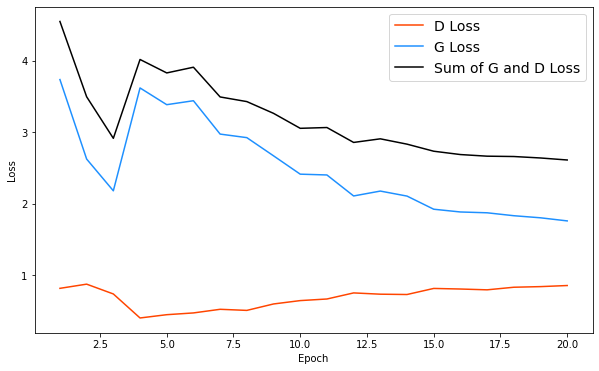

In [ ]:
import numpy as np 

plt.figure(figsize = (10,6))
plt.plot(np.arange(1, n_epoch+1), D_loss_hist, color='orangered', label='D Loss')
plt.plot(np.arange(1, n_epoch+1), G_loss_hist, color='dodgerblue', label='G Loss')
plt.plot(np.arange(1, n_epoch+1), np.array(G_loss_hist)+np.array(D_loss_hist), color='k', label='Sum of G and D Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(fontsize = 14)
plt.savefig('TrainLoss_GAN_Linear.png')


In [ ]:
os.getcwd()

'/content/drive/STATSM231A/HW4'

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_Gan_linear' + '.png')

In [ ]:
fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)

def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100))
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [ ]:
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()


In [ ]:
for epoch in range(n_epoch):
    p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=False, show = True, path=p, isFix=False)
    show_result((epoch+1), save=False, show = True, path=fixed_p, isFix=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# with torch.no_grad():
#     test_z = Variable(torch.randn(bs, z_dim).to(device))
#     generated = G(test_z)

#     save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + '.png')

torch.Size([100, 784])

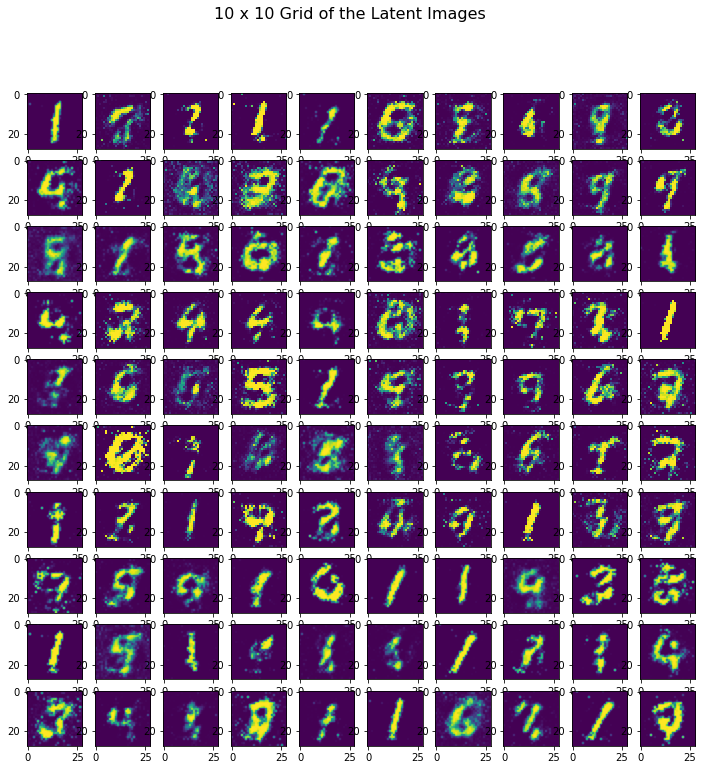

In [ ]:
def imgshow(grid_size, model, reconstruction = False):
  # plt.figure(figsize = (20,20))
  fig, ax = plt.subplots(grid_size[0],grid_size[1], figsize = (12,12))
  if reconstruction: 
    fig.suptitle('%s x %s Grid of the Latent Images'%(grid_size[0], grid_size[1]), fontsize = 16)
  else: 
    fig.suptitle('%s x %s Grid of the Latent Images'%(grid_size[0], grid_size[1]), fontsize = 16)
  s = np.arange(grid_size[0]*grid_size[1]).reshape(grid_size[0],grid_size[1])

  for i in range(grid_size[0]):
    for j in range(grid_size[1]):
      ax[i,j].imshow(model[s[i,j]].cpu().reshape(28,28))
  
  plt.show()
  fig.savefig('latent_gan_linear.png')
grid_size = [10,10]

imgshow(grid_size, generated, reconstruction= True)